In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data

import scipy

In [36]:
df = pd.read_csv("C:/Users/danie/Projects/ISLP_labs/5.Py.1.csv")
df

,X1,X2,y
0,1.297720,0.805921,0.298968
1,1.267323,0.799034,0.318134
2,1.236882,0.792169,0.337201
3,1.206317,0.785296,0.356121
4,1.175553,0.778385,0.374842
...,...,...,...
995,-0.771835,0.809153,0.202607
996,-0.770044,0.888314,0.212606
997,-0.768427,0.967673,0.222502
998,-0.766932,1.047105,0.232284


In [37]:
y = df['y']    # output variable, the median value of owner-occupied homes in $1000s
X = df[['X1', 'X2']]  # input variables
X = sm.add_constant(X)  # add intercept term
regressor_OLS = sm.OLS(y, X)  # We create a model object from statsmodels ordinary least squares regression
fitted = regressor_OLS.fit() # We fit the model to the data
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     66.14
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.06e-27
Time:                        06:26:00   Log-Likelihood:                -810.66
No. Observations:                1000   AIC:                             1627.
Df Residuals:                     997   BIC:                             1642.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2658      0.020     13.372      0.000       0.227       0.305
X1             0.1453      0.026      5.604      0.000       0.094       0.196
X2             0.3134      0.029     10.722      0.000       0.256       0.371
==============================================================================
Omnibus:                        9.703   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               13.694
Skew:                          -0.065   Prob(JB):                      0.00106
Kurtosis:                       3.558   Cond. No.                         2.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: >

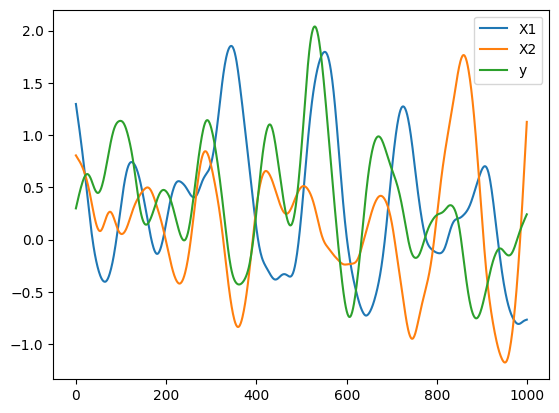

In [38]:
df.plot()

In [39]:
df.columns

Index(['X1', 'X2', 'y'], dtype='object')

$$
    \hat α = \frac{\hat σ^2_Y − \hat σ_{XY}}{\hat σ^2_X + \hat σ^2_Y − 2\hat σ_{XY}}
$$


In [40]:
def beta1_func(df, idx):
    X = df.loc[idx, ['X1', 'X2']]
    y = df.loc[idx, 'y']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.params['X1']

In [41]:
df.shape

(1000, 3)

In [42]:
def boot_SE(func,
            df,
            n=None,
            B=1000,
            seed=0):
    
    rng = np.random.default_rng(seed)
    
    first_, second_ = 0, 0
    
    n = n or df.shape[0]
    
    for _ in range(B):
        i = rng.choice(df.index,
                         n,
                         replace=True)
        value = func(df, i)
        first_ += value
        second_ += value**2
    
    return np.sqrt(second_ / B - (first_ / B)**2)

In [43]:
boot_SE(beta1_func, df)

0.02812391371830118

In [44]:
new_rows = np.r_[
    slice(0,100),
    slice(100,200),
    slice(200,300), 
    slice(300,400), 
    slice(400,500),
    slice(500,600), 
    slice(600,700), 
    slice(700,800),
    slice(800,900), 
    slice(900,1000),
]

new_df = df.iloc[new_rows]


In [45]:
def boot_SE_block(func,
                   df,
                   block_size,
                   n_blocks=None,
                   B=1000,
                   seed=0):

    rng = np.random.default_rng(seed)

    n_total_rows = df.shape[0]

    num_available_blocks = n_total_rows // block_size

    if n_blocks is None:
        n_blocks = num_available_blocks
    elif n_blocks > num_available_blocks:
        raise ValueError(f"n_blocks ({n_blocks}) cannot be greater than the number of available blocks ({num_available_blocks}).")

    first_, second_ = 0, 0

    for _ in range(B):
        # Randomly choose n_blocks with replacement
        sampled_block_indices = rng.choice(np.arange(num_available_blocks), size=n_blocks, replace=True)

        # Get the row indices corresponding to the sampled blocks
        indices = []
        for block_index in sampled_block_indices:
            start_index = block_index * block_size
            end_index = min((block_index + 1) * block_size, n_total_rows) # Handle the last block
            indices.extend(range(start_index, end_index))

        # Ensure we sample exactly n_blocks * block_size (or less for the last block) rows
        sampled_df = df.iloc[indices]

        # Apply the function to the resampled data
        value = func(sampled_df, sampled_df.index) # Pass the index of the resampled df
        first_ += value
        second_ += value**2

    return np.sqrt(second_ / B - (first_ / B)**2)

In [46]:
# Example Usage with your DataFrame (assuming df is already defined)
np.random.seed(0)

"""
df = pd.DataFrame({'y': np.random.rand(1000),
                   'X1': np.random.rand(1000),
                   'X2': np.random.rand(1000)})
"""

block_size = 100
n_blocks_to_resample = 10

# Calculate the standard error using block bootstrapping
se_block = boot_SE_block(beta1_func, 
                         new_df, 
                         block_size, 
                         n_blocks=n_blocks_to_resample, 
                         B=1000, 
                         seed=0
                        )

print(f"Standard Error (Block Bootstrap, block size={block_size}, n_blocks={n_blocks_to_resample}): {se_block:.4f}")

# Calculate the standard error using the original bootstrap for comparison
se_original = boot_SE(beta1_func, df, B=1000, seed=0)
print(f"Standard Error (Original Bootstrap): {se_original:.4f}")

Standard Error (Block Bootstrap, block size=100, n_blocks=10): 0.2430
Standard Error (Original Bootstrap): 0.0281
